In [1]:
!pip install pynbody

     |████████████████████████████████| 7.9 MB 74.1 MB/s eta 0:00:01ta 0:00:01
     |████████████████████████████████| 96 kB 22.0 MB/s  eta 0:00:01
  Created wheel for posix-ipc: filename=posix_ipc-1.0.5-cp38-cp38-linux_x86_64.whl size=51507 sha256=d4397a408708958bc5789877836a4a4096cfc0a3b96f36bb50ac8092e06ff3f6
  Stored in directory: /home/llu/.cache/pip/wheels/43/61/9c/74680c621ba03a481db6d045150574d8eaf776a4547fc37585
Successfully built posix-ipc


In [1]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
simsnames = [i.split('_')[0][1:] for i in sims]


In [2]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob

In [9]:
glob.glob('g6.96e11_3x9/*.?????')[0].split('.')[-1]

'00664'

In [66]:
"""
for i in [3]:
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}
    snap = snaplookup[max(allsnaps_time)]

    print(snap)
    s = pb.load(snap)

    h=s.halos()
    pb.analysis.angmom.faceon(h[1])
    s.physical_units()

    gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
    sim = h[1][gal]

    disc = filt.Disc('20 kpc', '5 kpc')
    solar = filt.LowPass('r', '10 kpc') & filt.HighPass('r', '6 kpc')

    sol = h[1].s[solar & disc]
    

    # birth data
    birth_data = pickle.load(open('./'+simname+'/g'+simsnames[i]+'_abundance_position_federico.dat','rb'), encoding='latin1')
    
    birth_pos = [[],[],[]]
    birth_pos[0], birth_pos[1], birth_pos[2] = birth_data['x_birth'],birth_data['y_birth'],birth_data['z_birth']
    birth_pos = np.array(birth_pos)
    
    birth_iord = birth_data['iords_form']
    birth_z0 = birth_data['iords_z0']
    age = birth_data['age']

    good = np.in1d(birth_iord,sim.s['iord'],assume_unique=True)
    good2 = np.in1d(sim.s['iord'],birth_iord[good],assume_unique=True)
    
    stars = sim.s[good2]
    birth_iord = birth_iord[good]
    birth_pos = birth_pos[:,good]
    birth_r = np.sqrt(birth_pos[0]*birth_pos[0] + birth_pos[1]*birth_pos[1])
    
    idx = np.in1d(birth_z0, birth_iord)

    birth_data = pd.DataFrame({'age':age[idx], 'Rbir':birth_r, 
                               'iord':birth_iord, 'zbir':birth_pos[2]})
    
    
    # save z=0 snap
    cols = np.append(stars.keys(),['ofe','feh'])
    this_snap = {j:stars[j] for j in cols if (('pos' not in j)&('vel' not in j))}
    
    data = pd.DataFrame(this_snap)
    
    data = pd.merge(data, birth_data, left_on='iord', right_on='iord', how='inner')
    
    # save as pkl
    data.to_pickle('g'+simsnames[i]+'_z_0.pkl')
""" 

  0%|          | 0/2 [00:00<?, ?it/s]

g2.79e12_3x6
g2.79e12_3x6/2.79e12.02000


 50%|█████     | 1/2 [04:18<04:18, 258.88s/it]

g7.55e11_3x9
g7.55e11_3x9/7.55e11.01024


100%|██████████| 2/2 [08:01<00:00, 240.74s/it]


In [4]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread):
    data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [50]:
def calcRbir_cv(data, fold=5):
    fold = int(fold)

    args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(fold)], [np.std(weights[i,:]) for i in range(fold)], y, ypred



  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


 17%|█▋        | 1/6 [00:04<00:22,  4.43s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


 33%|███▎      | 2/6 [00:09<00:19,  4.99s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


 50%|█████     | 3/6 [00:18<00:19,  6.55s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


 83%|████████▎ | 5/6 [00:31<00:06,  6.74s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


100%|██████████| 6/6 [00:40<00:00,  6.72s/it]


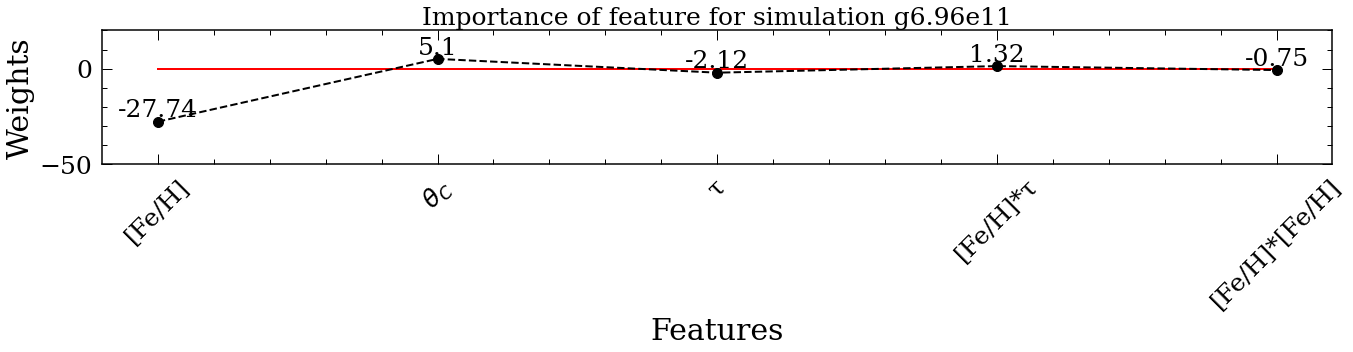

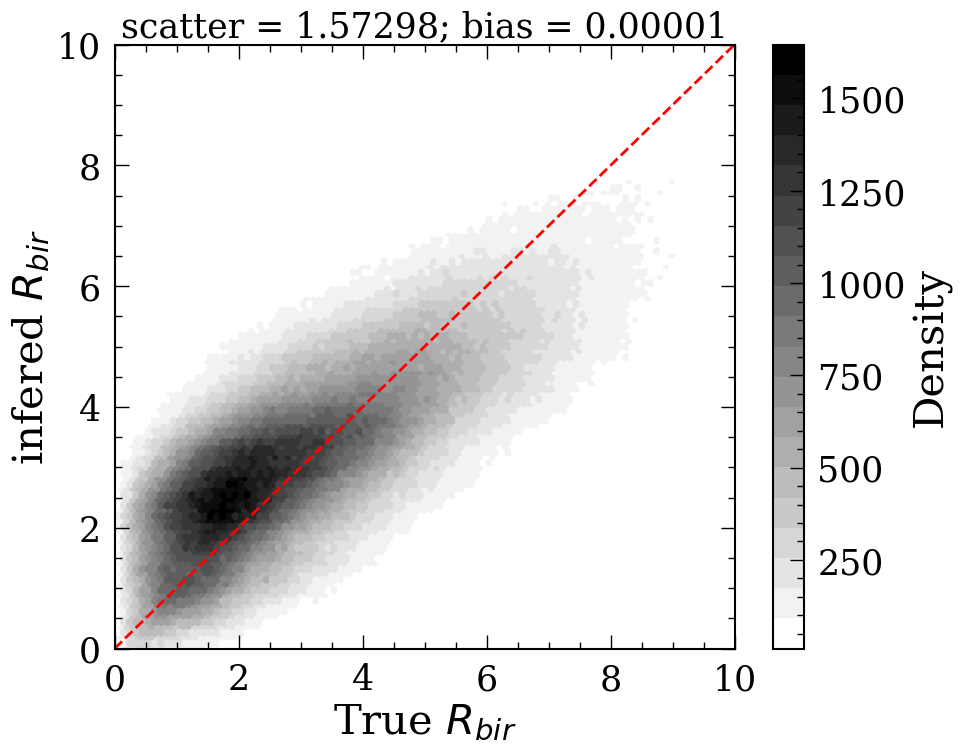

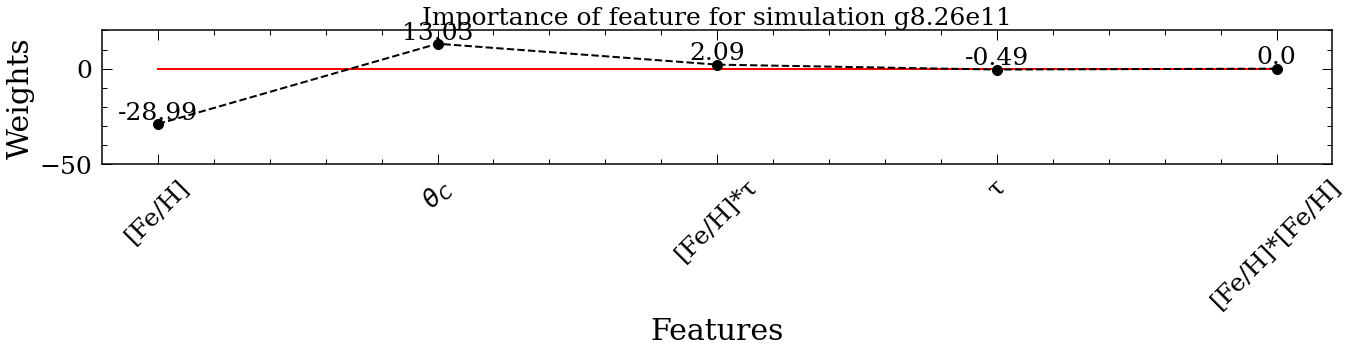

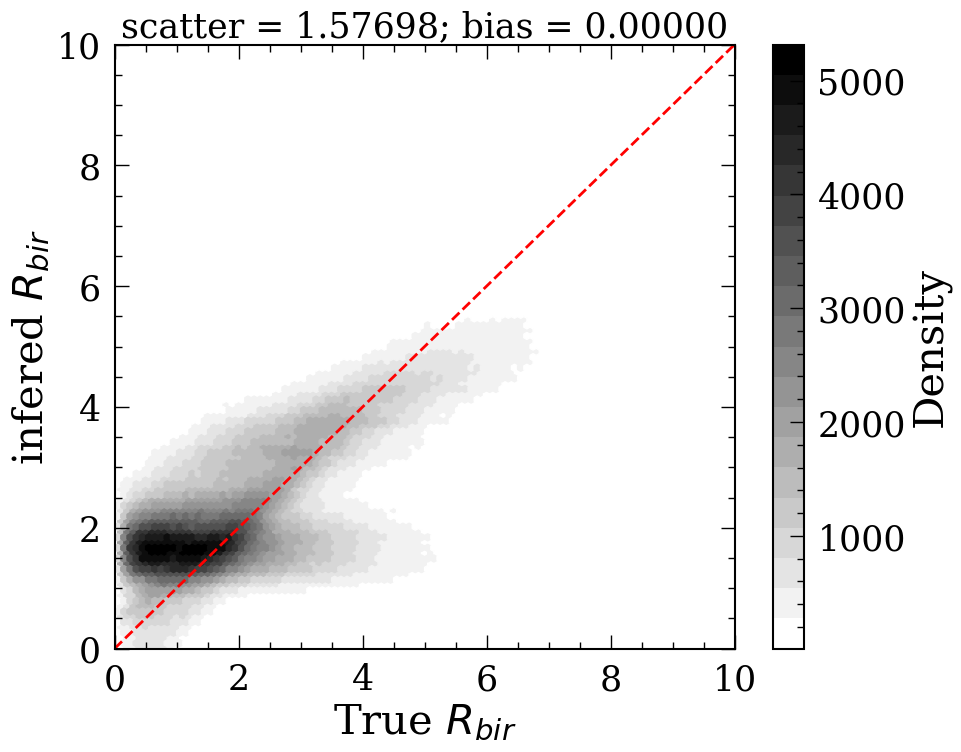

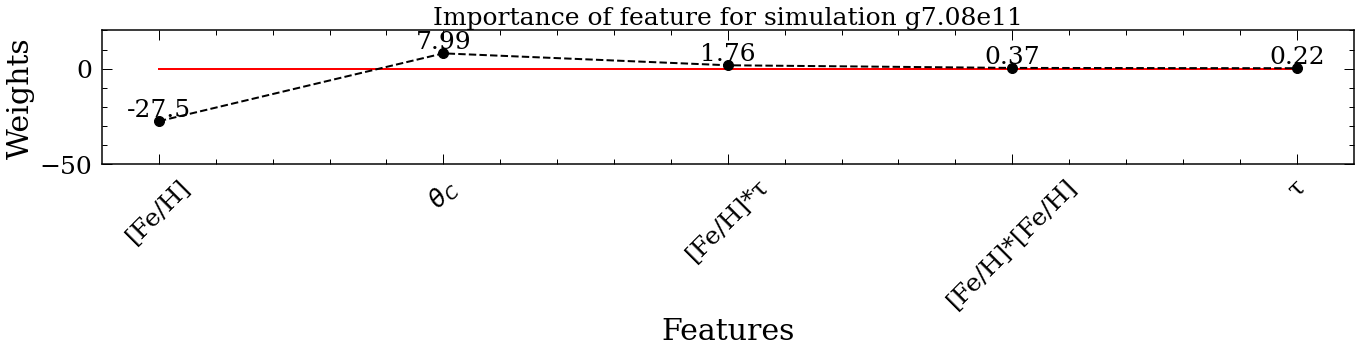

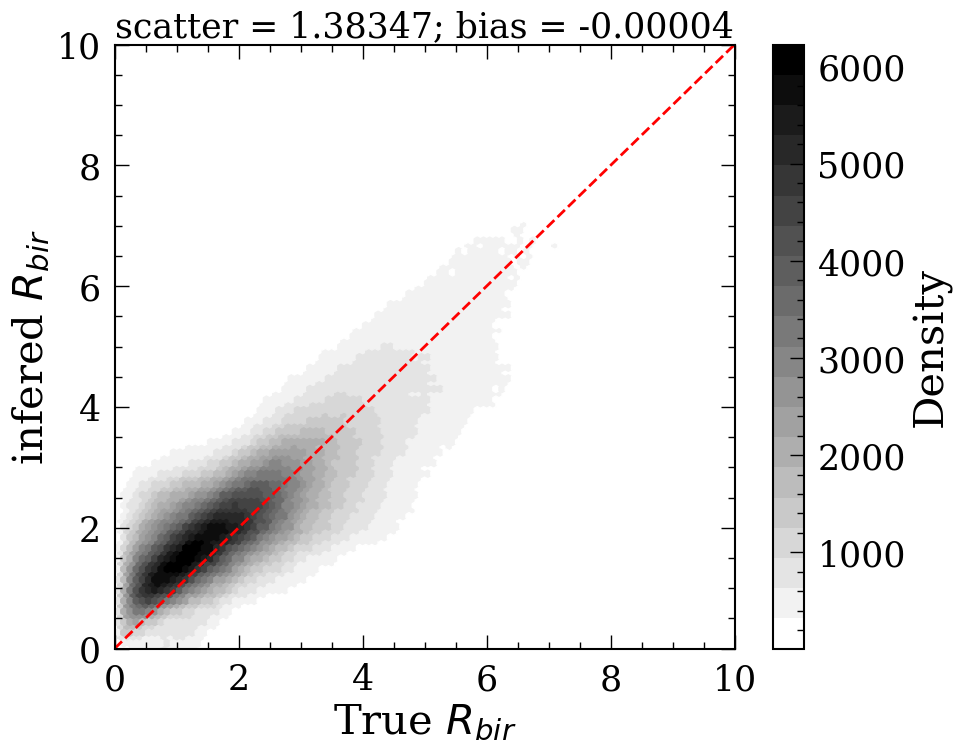

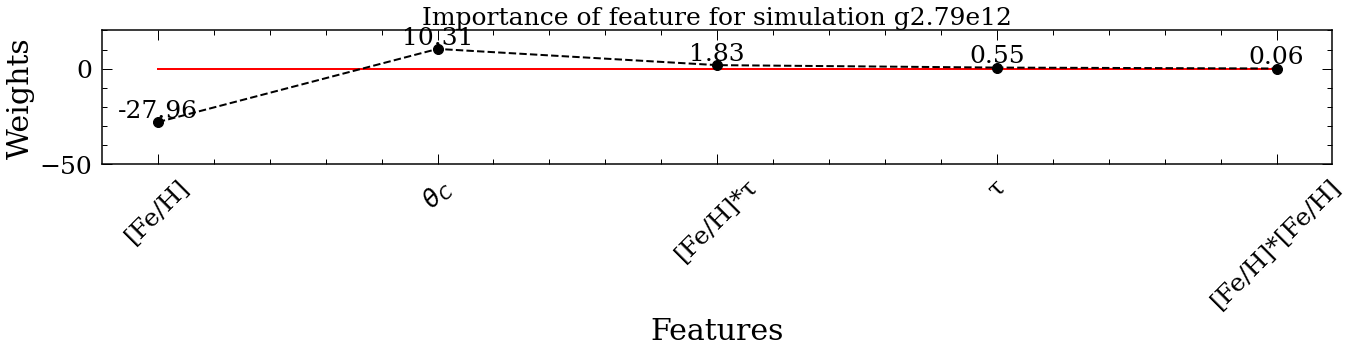

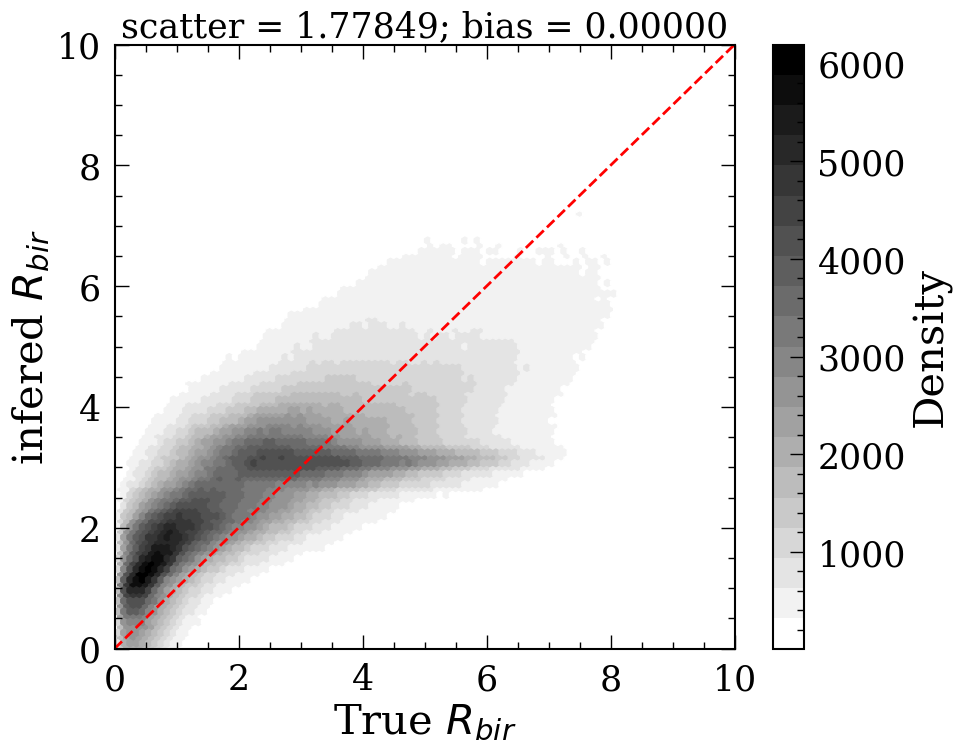

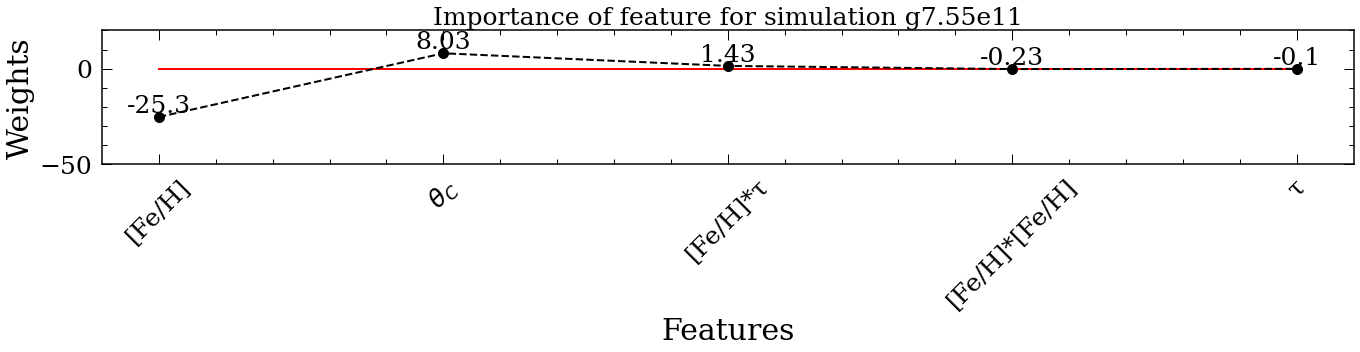

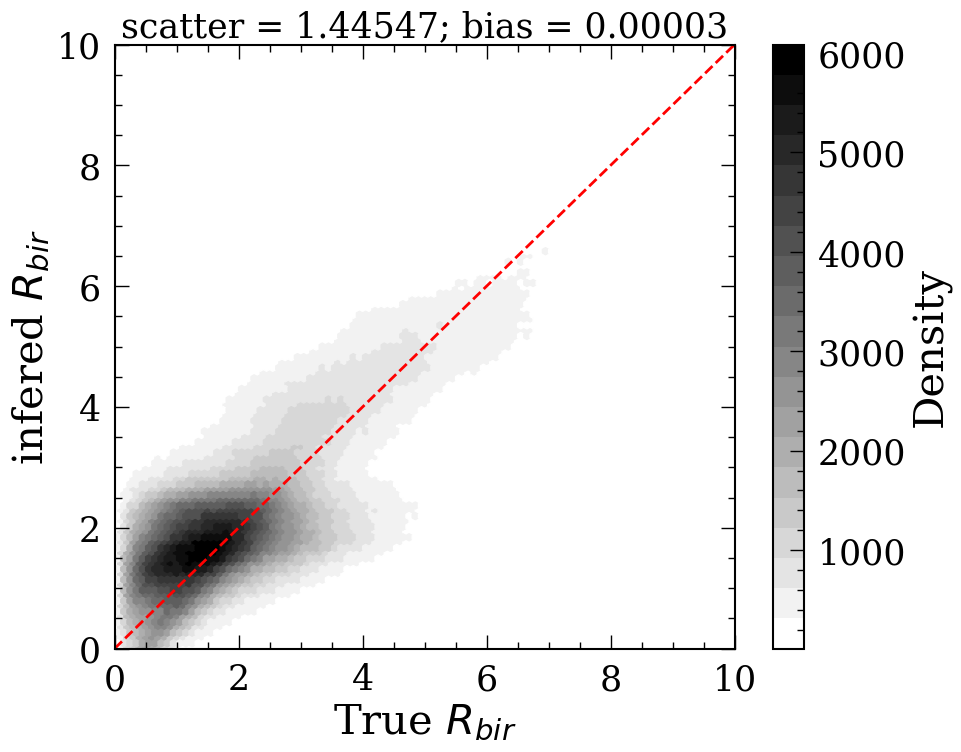

In [51]:
from itertools import combinations_with_replacement
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=30
    zcut_thread=5

    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')
    
    print('Calculating weights...')
    allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
    print('Finished calculating weights...')
    
    plt.figure(figsize=(19,5))
    absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
    weights_imp, allnames = weights_imp[::-1], allnames[::-1]
    plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
    plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
    plt.xticks(range(len(allnames)), allnames, rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Weights')
    plt.ylim([-50,20])
    plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

    for i, txt in enumerate(weights_imp):
        txt = np.round(txt,2)
        plt.annotate(txt, (i, weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
    plt.tight_layout()
    plt.savefig(simsnames[i]+'_importance.png')
    
    xs = np.linspace(0, 30, 100)
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)
    cmap = plt.cm.get_cmap('binary',20)
    plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
    plt.plot(xs, xs, "r--")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth.png')
    